In [210]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from tabulate import tabulate
import warnings
warnings.filterwarnings('ignore')

In [211]:
def coupon_payment_dates(single_bond_data_df, oldest_date):
    '''Take in a dataframe contianing the data for a single bond. Calculate all of the coupon payment dates starting at
       the maturity date, until the begining of the data frame'''
    
    maturity_date = pd.to_datetime(single_bond_data_df['Maturity'].iloc[0])
    payment_dates = [maturity_date]  #Get maturity date of bond
    num_payments_per_year = single_bond_data_df['Cpn Freq'].iloc[0]     #Get number of coup payments per year
    yrs_to_matur = (maturity_date - pd.to_datetime(oldest_date)).days / 365 #Calculate years to maturity
    num_payments = math.ceil(yrs_to_matur * num_payments_per_year)  #Calculate total number of payments
        
    payment_dates = pd.date_range(end=maturity_date, periods=num_payments, freq=f'{int(365/num_payments_per_year)}D')
        
    return payment_dates
    

In [212]:
def calc_single_bond_return(single_bond_data_df):
    '''Pass in the bond data for a single bond for every quarter it is in the investible universe. Calculate the return
       of the bond between quarters. Returns the weighted returns of the bond per quarter in percentages'''
    
    #Find the coupon payment dates for the bond 
    coupon_dates_all = coupon_payment_dates(single_bond_data_df, single_bond_data_df['Date'].iloc[0])
    
    
    all_quarter_returns = [0] * len(single_bond_data_df)
    for i in range(1, len(single_bond_data_df['Date'])):
        #Select the coup dates that occured this Quarter
        coupon_dates = coupon_dates_all[(coupon_dates_all <= pd.to_datetime(single_bond_data_df['Date'].iloc[i])) & (coupon_dates_all >= pd.to_datetime(single_bond_data_df['Date'].iloc[i-1]))]
        #Assume 100 face for coupon payments
        coupon_rate = (single_bond_data_df['Cpn'].iloc[0] / single_bond_data_df['Cpn Freq'].iloc[0]) / 100    #Want rate in decimal form
        coupon_cashflows = 100 * coupon_rate * len(coupon_dates)
        
        #Check if matures between quarters
        if (single_bond_data_df['Date'].iloc[i] >= single_bond_data_df['Maturity'].iloc[i-1]) and single_bond_data_df['Date'].iloc[i-1] <= single_bond_data_df['Maturity'].iloc[i-1]:
            total_proceeds = coupon_cashflows + 100      #100 is FV of the bond
            last_price = single_bond_data_df['Ask Price'].iloc[i-1]
            total_return = (total_proceeds - last_price) / last_price
            all_quarter_returns[i] = total_return
        
        else:
            current_price = single_bond_data_df['Bid Price'].iloc[i]
            last_price = single_bond_data_df['Ask Price'].iloc[i-1]
            total_proceeds = coupon_cashflows + current_price
            total_return = (total_proceeds - last_price) / last_price
            all_quarter_returns[i] = total_return

    single_bond_data_df['Returns'] = all_quarter_returns
    single_bond_data_df['Weighted Returns'] = single_bond_data_df['Returns'] * single_bond_data_df['Weights'].shift(1)
    single_bond_data_df['Weighted Returns'].iloc[0] = 0
    single_bond_data_df['Shifted Weights'] = single_bond_data_df['Weights'].shift(1)
    #print(single_bond_data_df)
    return single_bond_data_df 

In [270]:
def calc_single_bond_return_notransaction_costs(single_bond_data_df):
    '''Pass in the bond data for a single bond for every quarter it is in the investible universe. Calculate the return
       of the bond between quarters. Returns the weighted returns of the bond per quarter in percentages'''
    
    #Find the coupon payment dates for the bond 
    coupon_dates_all = coupon_payment_dates(single_bond_data_df, single_bond_data_df['Date'].iloc[0])
    
    
    all_quarter_returns = [0] * len(single_bond_data_df)
    for i in range(1, len(single_bond_data_df['Date'])):
        #Select the coup dates that occured this Quarter
        coupon_dates = coupon_dates_all[(coupon_dates_all <= pd.to_datetime(single_bond_data_df['Date'].iloc[i])) & (coupon_dates_all >= pd.to_datetime(single_bond_data_df['Date'].iloc[i-1]))]
        #Assume 100 face for coupon payments
        coupon_rate = (single_bond_data_df['Cpn'].iloc[0] / single_bond_data_df['Cpn Freq'].iloc[0]) / 100    #Want rate in decimal form
        coupon_cashflows = 100 * coupon_rate * len(coupon_dates)
        
        #Check if matures between quarters
        if (single_bond_data_df['Date'].iloc[i] >= single_bond_data_df['Maturity'].iloc[i-1]) and single_bond_data_df['Date'].iloc[i-1] <= single_bond_data_df['Maturity'].iloc[i-1]:
            total_proceeds = coupon_cashflows + 100      #100 is FV of the bond
            last_price = (single_bond_data_df['Ask Price'].iloc[i-1] + single_bond_data_df['Bid Price'].iloc[i-1]) / 2
            total_return = (total_proceeds - last_price) / last_price
            all_quarter_returns[i] = total_return
        
        else:
            current_price = (single_bond_data_df['Bid Price'].iloc[i] + single_bond_data_df['Ask Price'].iloc[i]) / 2
            last_price = (single_bond_data_df['Bid Price'].iloc[i-1] + single_bond_data_df['Ask Price'].iloc[i-1]) / 2
            total_proceeds = coupon_cashflows + current_price
            total_return = (total_proceeds - last_price) / last_price
            all_quarter_returns[i] = total_return

    single_bond_data_df['Returns'] = all_quarter_returns
    single_bond_data_df['Weighted Returns'] = single_bond_data_df['Returns'] * single_bond_data_df['Weights'].shift(1)
    single_bond_data_df['Weighted Returns'].iloc[0] = 0

    return single_bond_data_df 

In [214]:
def df_formatter(df):
    
    df_formatted = pd.DataFrame()
    df_formatted['Date'] = df['Date']
    df_formatted['CUSIP'] = df['CUSIP']
    df_formatted['Weights'] = df['Weights']
    
    # Replace NaN values in 'Returns' column with 0
    df_formatted['Returns'] = df['Returns'].fillna(0)
    
    # Calculate 'Weighted_Returns'
    df_formatted['Weighted_Returns'] = df['Weighted Returns']
    #df_formatted['Weighted_Returns'] = df_formatted['Weights'] * df_formatted['Returns']
    
    return df_formatted


In [215]:
def get_portcumret(Jim_df):
    # Create a list called "portret" with the value 1
    portret = [1]
    date = Jim_df['Date'].unique().tolist()
    
    
    # Break up the df by date
    for _, group in Jim_df.groupby('Date'):
        # For each date, sum the "Weighted_Ret" column
        sum_weighted_ret = group['Weighted_Returns'].sum()
        # Append each sum to the portret list
        portret.append(sum_weighted_ret)

    #Calculate cumulative return
    cum_ret = [(1 + portret[i]) * (1 + portret[i - 1]) - 1 for i in range(1, len(portret))]
    
    df = pd.DataFrame()
    df['Date'] = date
    df['Quarter Returns'] = portret[1:]
    df['Portfolio_cumulative_returns'] = cum_ret
    
    #Alternate Method
    returns_df = pd.DataFrame({'Date': df['Date'],
        'Returns': portret[1:]})
    print(returns_df)
    df['Portfolio_cumulative_returns_alt'] = (1 + returns_df['Returns']).cumprod() - 1
    
    return df

In [216]:
master_bond_data = pd.read_csv('Optimized_Weights_Master.csv')
master_bond_data['Date'] = pd.to_datetime(master_bond_data['Date'])
master_bond_data = master_bond_data.sort_values(by='Date')
master_bond_data['Maturity'] = pd.to_datetime(master_bond_data['Maturity'])
unique_cusip = master_bond_data['CUSIP'].unique()
#Select columns from existing dataframe
combined_returns_df = pd.DataFrame({
    'Date': [],
    'CUSIP': [],
    'Returns': [],  # Initialize a new column with no data
    'Weighted Returns': [],
    'Shifted Weights': []
})

#Loop over each unique bond and calculate its quarterly returns
for i in range(0, len(unique_cusip)):
    cusip = unique_cusip[i]
    filtered_df = master_bond_data[master_bond_data['CUSIP'] == cusip]
    bond_returns = calc_single_bond_return(filtered_df)
    #Selecting only the necessary columns from bond_returns_df
    bond_returns_subset = bond_returns[['Date', 'CUSIP', 'Returns', 'Weighted Returns', 'Shifted Weights']]
    combined_returns_df = pd.concat([combined_returns_df, bond_returns_subset], ignore_index=True)

merged_df = pd.merge(master_bond_data, combined_returns_df, on=['Date', 'CUSIP'], how='left')

In [217]:
merged_df.groupby("Date")["Shifted Weights"].sum()

Date
2013-09-30    0.000000
2013-12-31    0.999917
2014-03-31    1.000000
2014-06-30    1.000000
2014-09-30    1.000000
2014-12-31    1.000000
2015-03-31    0.999967
2015-06-30    1.000000
2015-09-30    0.970390
2015-12-31    0.919020
2016-03-31    0.960000
2016-06-30    0.920000
2016-09-30    1.000000
2016-12-31    0.960000
2017-03-31    1.000000
2017-06-30    0.980000
2017-09-30    0.950512
2017-12-31    0.960000
2018-03-31    0.999878
2018-06-30    0.980000
2018-09-30    0.930004
2018-12-31    1.000000
2019-03-31    0.990005
2019-06-30    1.000000
2019-09-30    0.999995
2019-12-31    0.972588
2020-03-31    0.982811
2020-06-30    0.999988
2020-09-30    1.000000
2020-12-31    1.000000
2021-03-31    1.000000
2021-06-30    0.990006
2021-09-30    0.950171
2021-12-31    0.999993
2022-03-31    0.999944
2022-06-30    1.000000
2022-09-30    1.000000
2022-12-31    0.999999
2023-03-31    0.999917
2023-06-30    0.999981
2023-09-30    1.000000
2023-12-31    0.979998
Name: Shifted Weights, dtype:

In [241]:
merged_df.groupby("Date")["Weights"].sum()

Date
2013-09-30    0.999917
2013-12-31    1.000000
2014-03-31    1.000000
2014-06-30    1.000000
2014-09-30    1.000000
2014-12-31    0.999967
2015-03-31    1.000000
2015-06-30    1.000000
2015-09-30    0.999997
2015-12-31    1.000000
2016-03-31    1.000000
2016-06-30    1.000000
2016-09-30    1.000000
2016-12-31    1.000000
2017-03-31    1.000000
2017-06-30    1.000000
2017-09-30    1.000000
2017-12-31    0.999878
2018-03-31    1.000000
2018-06-30    1.000000
2018-09-30    1.000000
2018-12-31    1.000000
2019-03-31    1.000000
2019-06-30    0.999995
2019-09-30    1.000000
2019-12-31    1.000000
2020-03-31    0.999988
2020-06-30    1.000000
2020-09-30    1.000000
2020-12-31    1.000000
2021-03-31    1.000000
2021-06-30    1.000000
2021-09-30    0.999993
2021-12-31    0.999944
2022-03-31    1.000000
2022-06-30    1.000000
2022-09-30    0.999999
2022-12-31    0.999917
2023-03-31    0.999981
2023-06-30    1.000000
2023-09-30    0.999998
2023-12-31    0.999897
Name: Weights, dtype: float64

In [218]:
combined_returns_df.to_csv('combined_returns.csv', index=False)

In [219]:
merged_df.to_csv('All_Data_All_Dates_Returns_Included.csv', index=False)

In [220]:
#Insert File Path Here
filepath = 'All_Data_All_Dates_Returns_Included.csv'

          Date   Returns
0   2013-09-30  0.000000
1   2013-12-31 -0.004271
2   2014-03-31  0.033078
3   2014-06-30  0.025302
4   2014-09-30  0.008677
5   2014-12-31  0.016809
6   2015-03-31  0.014530
7   2015-06-30 -0.036359
8   2015-09-30  0.009077
9   2015-12-31 -0.005551
10  2016-03-31  0.031016
11  2016-06-30  0.031146
12  2016-09-30  0.015890
13  2016-12-31 -0.028403
14  2017-03-31  0.016404
15  2017-06-30  0.013316
16  2017-09-30  0.022059
17  2017-12-31  0.010370
18  2018-03-31 -0.016796
19  2018-06-30 -0.007232
20  2018-09-30  0.000559
21  2018-12-31  0.005348
22  2019-03-31  0.041549
23  2019-06-30  0.039504
24  2019-09-30  0.025543
25  2019-12-31  0.007729
26  2020-03-31 -0.020407
27  2020-06-30  0.109773
28  2020-09-30  0.035101
29  2020-12-31  0.032581
30  2021-03-31 -0.035579
31  2021-06-30  0.036809
32  2021-09-30  0.005064
33  2021-12-31  0.003408
34  2022-03-31 -0.077443
35  2022-06-30 -0.075441
36  2022-09-30 -0.046832
37  2022-12-31  0.039924
38  2023-03-31  0.042999


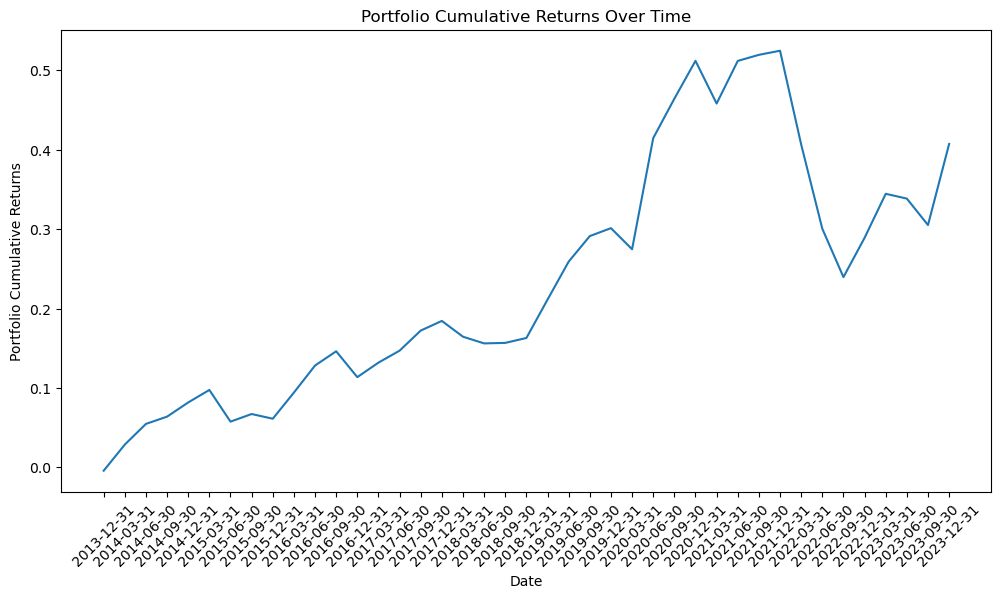

,Date,Quarter Returns,Portfolio_cumulative_returns,Portfolio_cumulative_returns_alt
1,2013-12-31,-0.004271,-0.004271,-0.004271
2,2014-03-31,0.033078,0.028666,0.028666
3,2014-06-30,0.025302,0.059217,0.054693
4,2014-09-30,0.008677,0.034198,0.063845
5,2014-12-31,0.016809,0.025632,0.081727
6,2015-03-31,0.014530,0.031583,0.097444
7,2015-06-30,-0.036359,-0.022357,0.057542
8,2015-09-30,0.009077,-0.027612,0.067142
9,2015-12-31,-0.005551,0.003476,0.061218
10,2016-03-31,0.031016,0.025292,0.094133


In [227]:
#Run this
testdf = pd.read_csv(filepath)
testdf_form = df_formatter(testdf)

# Example usage
cumulative_returns_df = get_portcumret(testdf_form)
cumulative_returns_df = cumulative_returns_df[1:]

x = cumulative_returns_df['Date']
y = cumulative_returns_df['Portfolio_cumulative_returns']
y_alt = cumulative_returns_df['Portfolio_cumulative_returns_alt']

plt.figure(figsize=(12, 6))
#plt.plot(x, y)
plt.plot(x, y_alt)
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Portfolio Cumulative Returns')
plt.title('Portfolio Cumulative Returns Over Time')
plt.show()
cumulative_returns_df

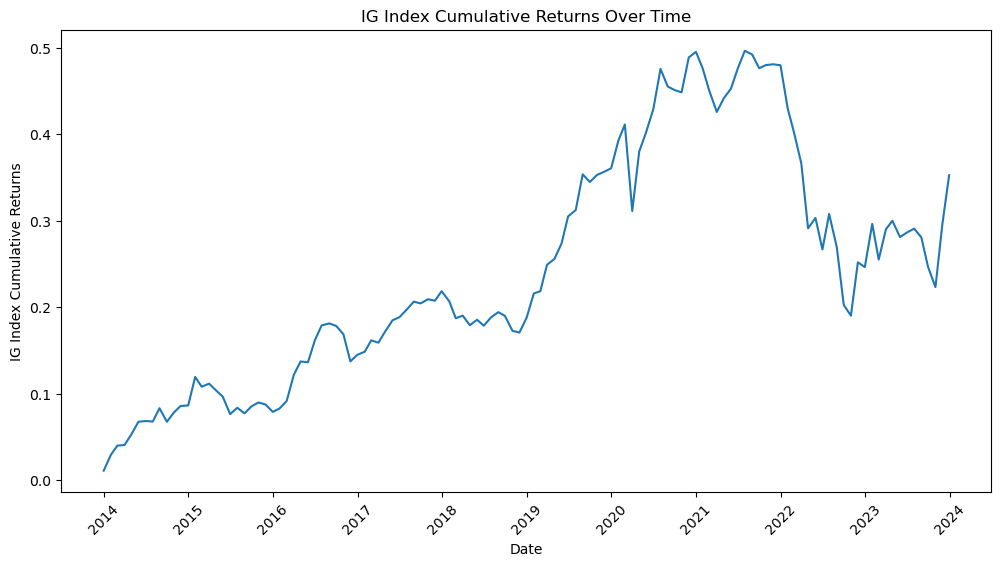

In [228]:
IG_index_df = pd.read_excel('LUACTRUU Index.xlsx')
IG_index_df['Date'] = pd.to_datetime(IG_index_df['Date'])
IG_index_df = IG_index_df.sort_values(by='Date')
IG_index_df = IG_index_df[(IG_index_df['Date'] >= '2013-09-30') & (IG_index_df['Date'] <= '2023-12-31')]
IG_index_df['Returns'] = IG_index_df['Price'].pct_change()
IG_index_df['Cumulative_Returns'] = (1 + IG_index_df['Returns']).cumprod() - 1
IG_index_df['Cumulative_Returns'] = IG_index_df['Cumulative_Returns']

x_IG = IG_index_df['Date'].iloc[3:]
y_IG = IG_index_df['Cumulative_Returns'].iloc[3:]

plt.figure(figsize=(12, 6))
plt.plot(x_IG, y_IG)
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('IG Index Cumulative Returns')
plt.title('IG Index Cumulative Returns Over Time')
plt.show()

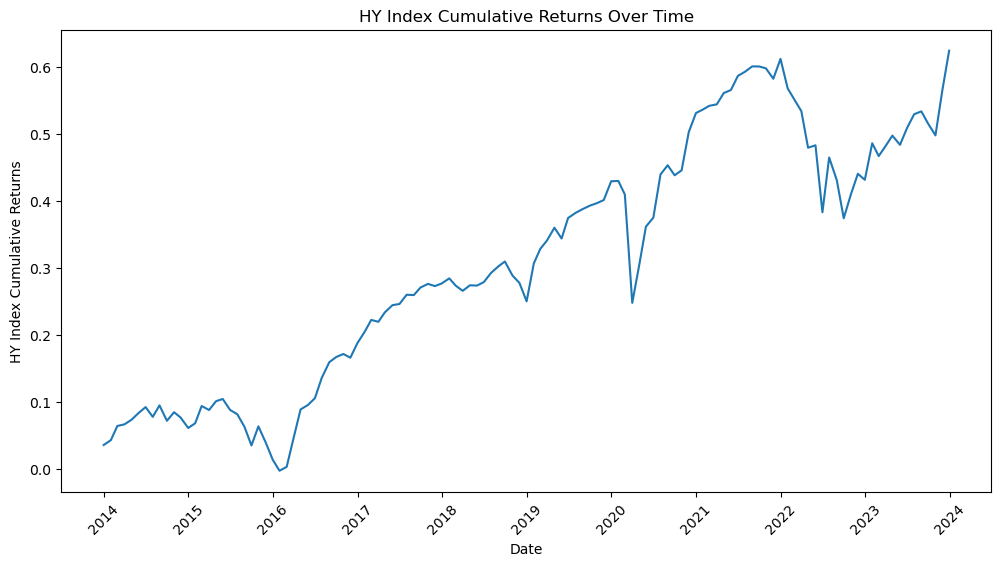

In [101]:
HY_index_df = pd.read_excel('LF98TRUU Index.xlsx')
HY_index_df['Date'] = pd.to_datetime(HY_index_df['Date'])
HY_index_df = HY_index_df.sort_values(by='Date')
HY_index_df = HY_index_df[(HY_index_df['Date'] >= '2013-09-30') & (HY_index_df['Date'] <= '2023-12-31')]
HY_index_df['Returns'] = HY_index_df['Price'].pct_change()
HY_index_df['Cumulative_Returns'] = (1 + HY_index_df['Returns']).cumprod() - 1
HY_index_df['Cumulative_Returns'] = HY_index_df['Cumulative_Returns']

x_HY = HY_index_df['Date'].iloc[3:]
y_HY = HY_index_df['Cumulative_Returns'].iloc[3:]

plt.figure(figsize=(12, 6))
plt.plot(x_HY, y_HY)
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('HY Index Cumulative Returns')
plt.title('HY Index Cumulative Returns Over Time')
plt.show()

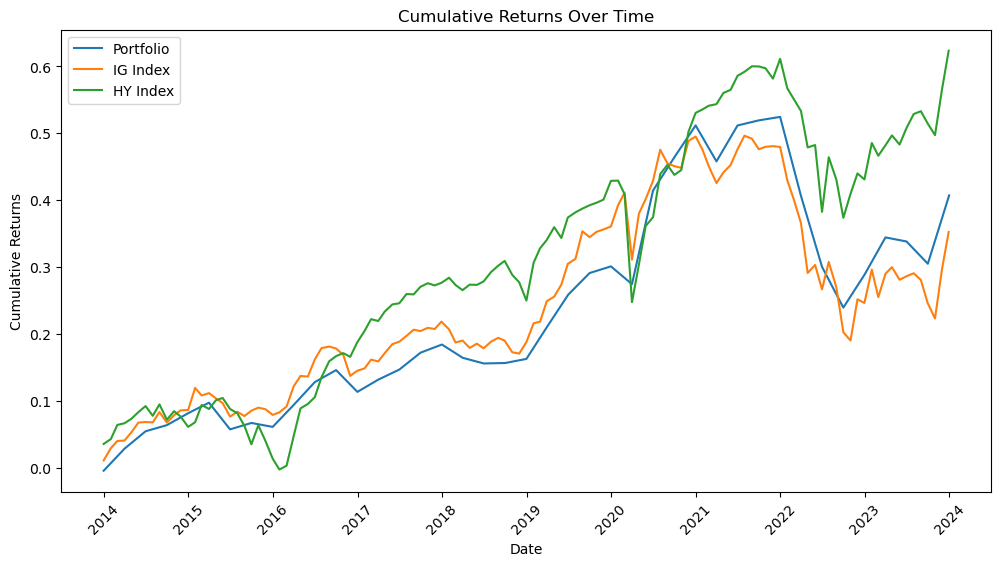

In [247]:
x = cumulative_returns_df['Date']
x = pd.to_datetime(cumulative_returns_df['Date'])
y = cumulative_returns_df['Portfolio_cumulative_returns']
y_alt = cumulative_returns_df['Portfolio_cumulative_returns_alt']

x_IG = IG_index_df['Date'].iloc[3:].reset_index(drop=True)
x_IG = pd.to_datetime(IG_index_df['Date'].iloc[3:])
y_IG = IG_index_df['Cumulative_Returns'].iloc[3:].reset_index(drop=True)

x_HY = HY_index_df['Date'].iloc[3:].reset_index(drop=True)
x_HY = pd.to_datetime(HY_index_df['Date'].iloc[3:])
y_HY = HY_index_df['Cumulative_Returns'].iloc[3:].reset_index(drop=True)

plt.figure(figsize=(12, 6))
#plt.plot(x, y, label='Portfolio')
plt.plot(x, y_alt, label='Portfolio')
plt.plot(x_IG, y_IG, label='IG Index')
plt.plot(x_HY, y_HY, label='HY Index')
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Cumulative Returns Over Time')
plt.legend()
plt.show()

In [268]:
#Format the Risk Free Rate Data
rf_df = pd.read_csv('Rf_Rate_Data.csv')
rf_df = rf_df[(pd.to_datetime(rf_df['Date'],format='%Y%m') >= '2013-09-30') & 
                     (pd.to_datetime(rf_df['Date'],format='%Y%m') <= '2023-12-31')]
rf_df = rf_df[pd.to_datetime(rf_df['Date'],format='%Y%m').dt.month.isin([3, 6, 9, 12])]
rf_df.index = cumulative_returns_df.index

portfolio_data = pd.DataFrame({
    'Date': [],
    'Returns': [],
    'RF': [],  # Initialize a new column with no data
    'Excess Returns': [],
})

#Calculate Portfolio Excess Mean Return, Vol, and Sharpe 
portfolio_data['Date'] = cumulative_returns_df['Date']
portfolio_data['Returns'] = cumulative_returns_df['Quarter Returns']
portfolio_data['RF'] = rf_df['RF'] / 100
portfolio_data['Excess Returns'] = portfolio_data['Returns'] - portfolio_data['RF']
port_vol = np.std(portfolio_data['Excess Returns']) * np.sqrt(4)
port_mean_excess_return = np.mean(portfolio_data['Excess Returns']) * 4
port_sharpe = port_mean_excess_return / port_vol
print(port_mean_excess_return)
print(port_vol)
print(port_sharpe)
print()

#Calculate IG Index Stats
IGindex_df = IG_index_df[3:]
IGindex_df = IGindex_df[(pd.to_datetime(IGindex_df['Date'],format='%Y%m') >= '2013-09-30') & 
                     (pd.to_datetime(IGindex_df['Date'],format='%Y%m') <= '2023-12-31')]
#IGindex_df = IGindex_df[pd.to_datetime(IGindex_df['Date'],format='%Y%m').dt.month.isin([3, 6, 9, 12])]
#IGindex_df.index = cumulative_returns_df.index

rf_mon_df = pd.read_csv('Rf_Rate_Data.csv')
rf_mon_df = rf_mon_df[(pd.to_datetime(rf_mon_df['Date'],format='%Y%m') >= '2013-09-30') & 
                     (pd.to_datetime(rf_mon_df['Date'],format='%Y%m') <= '2023-12-31')]
rf_mon_df = rf_mon_df[2:]
rf_mon_df.index = IGindex_df.index

IGindex_data = pd.DataFrame({
    'Date': [],
    'Returns': [],
    'RF': [],  # Initialize a new column with no data
    'Excess Returns': [],
})

IGindex_data['Date'] = IGindex_df['Date']
IGindex_data['Returns'] = IGindex_df['Returns']
IGindex_data['RF'] = rf_mon_df['RF'] / 100
IGindex_data['Excess Returns'] = IGindex_data['Returns'] - IGindex_data['RF']
IGindex_vol = np.std(IGindex_data['Excess Returns']) * np.sqrt(12)
IGindex_mean_excess_return = np.mean(IGindex_data['Excess Returns']) * 12
IGindex_sharpe = IGindex_mean_excess_return / IGindex_vol
print(IGindex_mean_excess_return)
print(IGindex_vol)
print(IGindex_sharpe)

0.03197435881038198
0.06982593271751882
0.4579152410284932

0.019450488287828138
0.06737869275137486
0.2886741712190795


# NO TRANSACTION COSTS (Mid Prices)

In [271]:
master_bond_data = pd.read_csv('Optimized_Weights_Master.csv')
master_bond_data['Date'] = pd.to_datetime(master_bond_data['Date'])
master_bond_data = master_bond_data.sort_values(by='Date')
master_bond_data['Maturity'] = pd.to_datetime(master_bond_data['Maturity'])
unique_cusip = master_bond_data['CUSIP'].unique()
#Select columns from existing dataframe
combined_returns_df = pd.DataFrame({
    'Date': [],
    'CUSIP': [],
    'Returns': [],  # Initialize a new column with no data
    'Weighted Returns': []
})

#Loop over each unique bond and calculate its quarterly returns
for i in range(0, len(unique_cusip)):
    cusip = unique_cusip[i]
    filtered_df = master_bond_data[master_bond_data['CUSIP'] == cusip]
    bond_returns = calc_single_bond_return_notransaction_costs(filtered_df)
    #Selecting only the necessary columns from bond_returns_df
    bond_returns_subset = bond_returns[['Date', 'CUSIP', 'Returns', 'Weighted Returns']]
    combined_returns_df = pd.concat([combined_returns_df, bond_returns_subset], ignore_index=True)

#master_bond_data['Returns'] = master_bond_data['CUSIP']
merged_df = pd.merge(master_bond_data, combined_returns_df, on=['Date', 'CUSIP'], how='left')

In [272]:
merged_df.to_csv('All_Data_No_Transaction_Costs.csv', index=False)

          Date   Returns
0   2013-09-30  0.000000
1   2013-12-31  0.003735
2   2014-03-31  0.040744
3   2014-06-30  0.032187
4   2014-09-30  0.015549
5   2014-12-31  0.024181
6   2015-03-31  0.022327
7   2015-06-30 -0.030051
8   2015-09-30  0.016884
9   2015-12-31  0.002647
10  2016-03-31  0.039620
11  2016-06-30  0.041051
12  2016-09-30  0.026751
13  2016-12-31 -0.018470
14  2017-03-31  0.026463
15  2017-06-30  0.022792
16  2017-09-30  0.030415
17  2017-12-31  0.018531
18  2018-03-31 -0.009358
19  2018-06-30  0.000968
20  2018-09-30  0.006962
21  2018-12-31  0.011403
22  2019-03-31  0.047910
23  2019-06-30  0.046900
24  2019-09-30  0.033600
25  2019-12-31  0.016070
26  2020-03-31 -0.009871
27  2020-06-30  0.122602
28  2020-09-30  0.046872
29  2020-12-31  0.043654
30  2021-03-31 -0.025497
31  2021-06-30  0.046077
32  2021-09-30  0.012950
33  2021-12-31  0.010954
34  2022-03-31 -0.070081
35  2022-06-30 -0.067585
36  2022-09-30 -0.038708
37  2022-12-31  0.048430
38  2023-03-31  0.052471


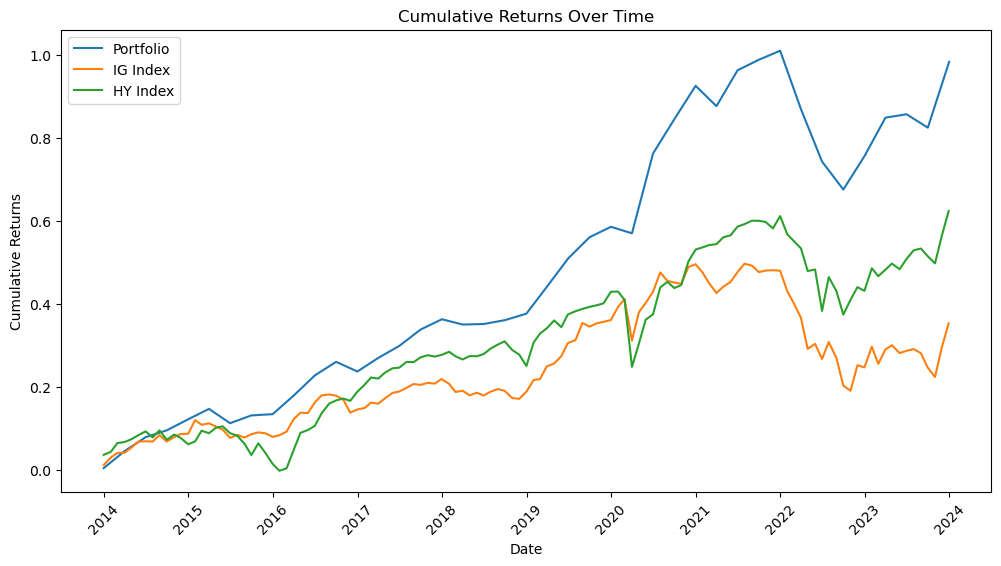

In [273]:
#Insert File Path Here
filepath = 'All_Data_No_Transaction_Costs.csv'

#Run this
testdf = pd.read_csv(filepath)
testdf_form = df_formatter(testdf)

# Example usage
cumulative_returns_notransaction_df = get_portcumret(testdf_form)
cumulative_returns_notransaction_df = cumulative_returns_notransaction_df[1:]

IG_index_df = pd.read_excel('LUACTRUU Index.xlsx')
IG_index_df['Date'] = pd.to_datetime(IG_index_df['Date'])
IG_index_df = IG_index_df.sort_values(by='Date')
IG_index_df = IG_index_df[(IG_index_df['Date'] >= '2013-09-30') & (IG_index_df['Date'] <= '2023-12-31')]
IG_index_df['Returns'] = IG_index_df['Price'].pct_change()
IG_index_df['Cumulative_Returns'] = (1 + IG_index_df['Returns']).cumprod() - 1
IG_index_df['Cumulative_Returns'] = IG_index_df['Cumulative_Returns']

HY_index_df = pd.read_excel('LF98TRUU Index.xlsx')
HY_index_df['Date'] = pd.to_datetime(HY_index_df['Date'])
HY_index_df = HY_index_df.sort_values(by='Date')
HY_index_df = HY_index_df[(HY_index_df['Date'] >= '2013-09-30') & (HY_index_df['Date'] <= '2023-12-31')]
HY_index_df['Returns'] = HY_index_df['Price'].pct_change()
HY_index_df['Cumulative_Returns'] = (1 + HY_index_df['Returns']).cumprod() - 1
HY_index_df['Cumulative_Returns'] = HY_index_df['Cumulative_Returns']

x = cumulative_returns_notransaction_df['Date']
x = pd.to_datetime(cumulative_returns_notransaction_df['Date'])
y = cumulative_returns_notransaction_df['Portfolio_cumulative_returns']
y_alt = cumulative_returns_notransaction_df['Portfolio_cumulative_returns_alt']

x_IG = IG_index_df['Date'].iloc[3:].reset_index(drop=True)
x_IG = pd.to_datetime(IG_index_df['Date'].iloc[3:])
y_IG = IG_index_df['Cumulative_Returns'].iloc[3:].reset_index(drop=True)

x_HY = HY_index_df['Date'].iloc[3:].reset_index(drop=True)
x_HY = pd.to_datetime(HY_index_df['Date'].iloc[3:])
y_HY = HY_index_df['Cumulative_Returns'].iloc[3:].reset_index(drop=True)

plt.figure(figsize=(12, 6))
plt.plot(x, y_alt, label='Portfolio')
plt.plot(x_IG, y_IG, label='IG Index')
plt.plot(x_HY, y_HY, label='HY Index')
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Cumulative Returns Over Time')
plt.legend()
plt.show()

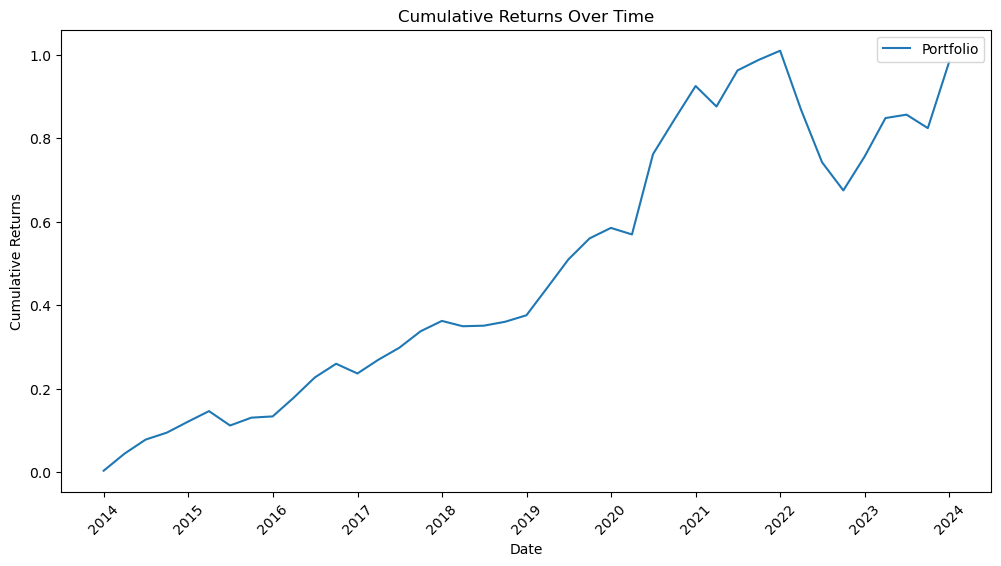

In [275]:
plt.figure(figsize=(12, 6))
plt.plot(x, y_alt, label='Portfolio')
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Cumulative Returns Over Time')
plt.legend()
plt.show()

In [86]:
cumulative_returns_notransaction_df

,Date,Portfolio_cumulative_returns
1,2013-12-31,0.005028
2,2014-03-31,0.044895
3,2014-06-30,0.091852
4,2014-09-30,0.058358
5,2014-12-31,0.041121
6,2015-03-31,0.056703
7,2015-06-30,0.004555
8,2015-09-30,-0.001197
9,2015-12-31,0.013923
10,2016-03-31,0.032610
